In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from math import log2
from collections import Counter
%config InlineBackend.figure_format = "svg"

In [25]:
labels = ['parents','has_nurs','form','children','housing','finance','social','health','recommend']
dataset = pd.read_csv('nursery.data',names=labels)
dataset

,parents,has_nurs,form,children,housing,finance,social,health,recommend
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [54]:
def load_data_and_split(data_path='./nursery.data', val_rate=0.2):
    """
    加载数据集并划分训练集和验证集
    :param data_path: 数据集路径
    :param val_rate: 验证集比例
    :return: 训练集列表，验证集列表，训练集标签列表，验证集标签列表
    """
    with open(data_path,'r') as openfile:
        data_lines = openfile.read().splitlines()  # 读取文件的所有行，忽略换行符
    data_list,label_list = [],[]
    for data_line in data_lines:
        data_line = data_line.split(",")
        data_list.append(list(data_line[0:-1]))
        label_list.append(data_line[-1])
    train_data, val_data, train_label, val_label = train_test_split(data_list,\
                                                                    label_list,\
                                                                    test_size=val_rate, 
                                                                    random_state=random.randint(0,1000),\
                                                                    shuffle=True)
    return train_data,val_data, train_label,val_label

In [2]:
import random
def load_data_and_split2(data_path='./nursery.data', val_rate=0.2):
    """
    加载数据集并划分训练集和验证集
    :param data_path: 数据集路径
    :param val_rate: 验证集比例
    :return: 训练集列表，验证集列表
    """
    with open('./nursery.data','r') as openfile:
        data_lines = openfile.read().splitlines()  # 读取文件的所有行，忽略换行符
    val_lines = random.sample(data_lines,k=int(len(data_lines)*0.2))
    train_data = np.array([])
    val_data = np.array([])
    cnt = []
    for data_line in data_lines:
        if data_line in val_lines:
            data_line = np.array(data_line.split(","))
            if len(data_line) == 9:
                val_data = np.append(val_data,data_line)
        else:
            data_line = np.array(data_line.split(","))
            if len(data_line) == 9:
                train_data = np.append(train_data,data_line)
    return train_data.reshape(-1,9),val_data.reshape(-1,9)

In [3]:
train_data, val_data = load_data_and_split2()

In [4]:
def calcShannonEnt(dataset):
    """
    计算给定数据集的香农熵
    :param dataset: 数据集
    :return: 香农熵
    """
    count = Counter(dataset[:,-1]) # 获取各类别以及对应的数量
    values = np.array(list(count.values()))/len(dataset) 
    return -np.sum(values*np.log2(values))

In [5]:
dataset = np.array([[1,1,'yes'],[1,1,'yes'],[1,0,'no'],[0,1,'no'],[0,1,'no']])
print(calcShannonEnt(dataset))
print(calcShannonEnt(train_data))

0.9709505944546686
1.7153556109145907


In [6]:
def splitDataSet(dataset, axis):
    feature_list = set(dataset[:,axis])
    result_dataset = []
    for feature in feature_list:
        filter_list = dataset[dataset[:,axis] == feature,:] # 过滤出第axis+1维属性等于feature的行
        reduce_list = np.concatenate((filter_list[:,: axis],filter_list[:,axis+1 :]),axis=1)
        result_dataset.append(reduce_list)
    return feature_list,result_dataset

In [56]:
result_dataset = splitDataSet(dataset, 0)
print(result_dataset)

[array([['1', 'no'],
       ['1', 'no']], dtype='<U11'), array([['1', 'yes'],
       ['1', 'yes'],
       ['0', 'no']], dtype='<U11')]


In [22]:
axis = 0
feature_list = set(dataset[:,axis])
result_dataset = []
for feature in feature_list:
    filter_list = dataset[dataset[:,axis] == feature,:] # 过滤出第axis+1维属性等于feature的行
    reduce_list = np.concatenate((filter_list[:,: axis],filter_list[:,axis+1 :]),axis=1)
    result_dataset.append(reduce_list.tolist())

[['1', 'no'], ['1', 'no']]
[['1', 'yes'], ['1', 'yes'], ['0', 'no']]


In [29]:
print(result_dataset)
for data in result_dataset:
    print(data)

[[['1', 'no'], ['1', 'no']], [['1', 'yes'], ['1', 'yes'], ['0', 'no']]]
[['1', 'no'], ['1', 'no']]
[['1', 'yes'], ['1', 'yes'], ['0', 'no']]


In [32]:
def chooseBestFeatureToSplit(dataset):
    baseEntropy = calcShannonEnt(dataset)
    infoGain_list = []
    for i in range(len(dataset[0])-1):
        _, split_dataset = splitDataSet(dataset,i)
        newEntropy = 0.0
        splitEntropy = 0.0
        for subset in split_dataset:
            ratio = len(subset)/len(dataset)
            newEntropy += ratio * calcShannonEnt(subset)
            splitEntropy -= ratio * log2(ratio)
        if splitEntropy <= 1e-9:
            infoGain_list.append(0)
        else:
            infoGain_list.append((baseEntropy - newEntropy)/splitEntropy)
    return np.argmax(infoGain_list)

In [33]:
dataSet = [['男','60-69','不及格','未'],
 ['男' ,'70-79' ,'良','未'],
 ['男' ,'60-69', '及格', '已'],
 ['男', '70-79', '及格', '未'],
 ['男', '60-69', '及格', '已'],
 ['男', '70-79', '良', '未'],
 ['男', '80-89', '良', '未'],
 ['男', '70-79', '不及格', '未'],
 ['男', '70-79', '良', '未']]
# labels = ['a','b','c','ddd']
for i in range(len(dataSet)):
    dataSet[i] = np.array(dataSet[i])
dataSet = np.array(dataSet)
print(chooseBestFeatureToSplit(dataSet))

1


In [93]:
baseEntropy = calcShannonEnt(dataset)
infoGain_list = []
for i in range(len(dataset[0])-1):
    _,split_dataset = splitDataSet(dataset,i)
    newEntropy = 0.0
    splitEntropy = 0.0
    for subset in split_dataset:
        ratio = len(subset)/len(dataset)
        newEntropy += ratio * calcShannonEnt(subset)
        splitEntropy -= ratio * log2(ratio)
    infoGain_list.append((baseEntropy - newEntropy)/splitEntropy)
print(infoGain_list)
print(np.argmax(infoGain_list))

[0.4325380677663126, 0.23679725954056524]
0


In [18]:
def majorityCnt(class_list):
    # 统计各个特征的出现次数，按降序排序
    count = sorted(Counter(class_list).items(),key = lambda x: x[1], reverse=True)
    return count[0][0]

In [8]:
def createTree(dataset, labels):
    class_list = dataset[:,-1]
    # 类别完全相同则停止划分
    if len(set(class_list)) == 1:
        return class_list[0]
    # 数据集只有一个特征时，返回出现次数最多的特征
    if len(dataset[0]) == 1:
        return majorityCnt(class_list)
    # 选择最佳划分特征
    bestFeat = chooseBestFeatureToSplit(dataset)
    # 最佳划分特征对应的标签
    bestFeatlabel = labels[bestFeat]
    # 递归建树
    myTree = {bestFeatlabel:{}}
    del(labels[bestFeat])
    splitedFeat,splitedDataSet = splitDataSet(dataset,bestFeat)
    for i, values in enumerate(splitedFeat):
        subLabels = labels[:]
        myTree[bestFeatlabel][values] = createTree(splitedDataSet[i],subLabels)
    return myTree

In [20]:
dataset2 = np.array([['a'],['a'],['s'],['s'],['a'],['s'],['s'],['s']])
# labels = ['parents','has_nurs','form','children','housing','finance','social','health','recommend']
labels = ['no surfacing','flippers']
train_tree = createTree(dataset,labels)
print(train_tree)

{'no surfacing': {'1': {'flippers': {'1': 'yes', '0': 'no'}}, '0': 'no'}}


In [13]:
import matplotlib.pylab as plt

#用来正常显示中文
plt.rcParams['font.sans-serif']=['SimHei']
#用来正常显示负号
plt.rcParams['axes.unicode_minus']=False

def getNumLeafs(myTree):
    #初始化树的叶子节点的个数
    numLeafs = 0
    #myTree.keys()获取树的非叶子节点’no surfacing'和‘flippers’
    #list(mytree.keys()[0]获取第一个键名‘no surfacing’
    firstStr = list(myTree.keys())[0]
    #通过键名获取与之对应的值，即{0:'no',1:{'flippers':{0:'no,1:'yes'}}}
    secondDict = myTree[firstStr]
    #遍历树，secondDict.keys()获取所有的键
    for key in secondDict.keys():
        #判断键是否为字典，键名1和其值就组成了一个字典，如果是字典则通过递归继续遍历，寻找叶子节点
        if type(secondDict[key]).__name__=='dict':
            numLeafs += getNumLeafs(secondDict[key])
        #如果不是字典，则叶子节点的数目就加1
        else:
            numLeafs += 1
        #返回叶子节点的数目
    return numLeafs

def getTreeDepth(mytree):
    #初始化树的深度
    maxDepth = 0
    #获取树的第一个键名
    firstStr = list(mytree.keys())[0]
    #获取键名所对应的值
    secondDict = mytree[firstStr]
    #遍历树
    for key in secondDict.keys():
        #如果获取的键是字典，树的深度加一
        if type(secondDict[key]).__name__=='dict':
            thisDepth = 1+ getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        #去深度最大值
        if thisDepth > maxDepth : maxDepth = thisDepth
    #返回树的深度
    return maxDepth

#设置画节点用的盒子的样式
decisionNode = dict(boxstyle = 'sawtooth', fc='0.8')
leafNode = dict(boxstyle = 'round4', fc = '0.8')

#设置画箭头的样式
arrow_args = dict(arrowstyle="<-")
#绘图相关参数的设置
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    #annotate函数是为绘制图上指定的数据点xy添加一个nodeTxt注释
    #nodeTxt是给数据点xy添加一个注释，xy为数据点的开始绘制的坐标,位于节点的中间位置
    #xycoords设置指定点xy的坐标类型，xytext为注释的中间点坐标，textcoords设置注释点坐标样式
    #bbox设置装注释盒子的样式,arrowprops设置箭头的样式
    '''
        figure points:表示坐标原点在图的左下角的数据点
        figure pixels:表示坐标原点在图的左下角的像素点
        figure fraction：此时取值是小数，范围是([0,1],[0,1]),在图的左下角时xy是（0,0），最右上角是(1,1)
        其他位置是按相对图的宽高的比例取最小值
        axes points : 表示坐标原点在图中坐标的左下角的数据点
        axes pixels : 表示坐标原点在图中坐标的左下角的像素点
        axes fraction : 与figure fraction类似，只不过相对于图的位置改成是相对于坐标轴的位置
    '''
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,
                            xycoords='axes fraction', xytext=centerPt, textcoords='axes fraction',
                            va='center', ha='center', bbox=nodeType, arrowprops=arrow_args)

#绘制线中间的文字（0和1）的绘制
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

#绘制树
def plotTree(myTree, parentPt, nodeTxt):
    #获取树的叶子节点
    numLeafs = getNumLeafs(myTree)
    #获取树的深度
    depth = getTreeDepth(myTree)
    #firstStr = mytree.keys()[0]
    #获取第一个键名
    firstStr = list(myTree.keys())[0]
    # 计算子节点的坐标
    cntrPt = (plotTree.xoff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yoff)
    # 绘制线上的文字
    plotMidText(cntrPt, parentPt, nodeTxt)
    # 绘制节点
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    # 获取第一个键值
    secondDict = myTree[firstStr]
    # 计算节点y方向上的偏移量，根据树的深度
    plotTree.yoff = plotTree.yoff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            # 递归绘制树
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            # 更新x的偏移量,每个叶子结点x轴方向上的距离为 1/plotTree.totalW
            plotTree.xoff = plotTree.xoff + 1.0 / plotTree.totalW
            # 绘制非叶子节点
            plotNode(secondDict[key], (plotTree.xoff, plotTree.yoff), cntrPt, leafNode)
            # 绘制箭头上的标志
            plotMidText((plotTree.xoff, plotTree.yoff), cntrPt, str(key))
    plotTree.yoff = plotTree.yoff + 1.0 / plotTree.totalD

#绘制决策树，inTree的格式为{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
def createPlot(inTree):
    #新建一个figure设置背景颜色为白色
    fig = plt.figure(1,facecolor='white')
    #清除figure
    fig.clf()
    axprops = dict(xticks=[],yticks=[])
    #创建一个1行1列1个figure，并把网格里面的第一个figure的Axes实例返回给ax1作为函数createPlot()
    #的属性，这个属性ax1相当于一个全局变量，可以给plotNode函数使用
    createPlot.ax1 = plt.subplot(111,frameon=False,**axprops)
    #获取树的叶子节点
    plotTree.totalW = float(getNumLeafs(inTree))
    #获取树的深度
    plotTree.totalD = float(getTreeDepth(inTree))
    #节点的x轴的偏移量为-1/plotTree.totlaW/2,1为x轴的长度，除以2保证每一个节点的x轴之间的距离为1/plotTree.totlaW*2
    plotTree.xoff = -0.5/plotTree.totalW
    plotTree.yoff = 1.0
    plotTree(inTree,(0.5,1.0),'')
    plt.show()

['性别', '学生干部', '综合成绩', '毕业论文', '就业情况']


C:\Users\86199\AppData\Local\Temp\ipykernel_20676\598793720.py:12: RuntimeWarning: invalid value encountered in double_scalars
  infoGain_list.append((baseEntropy - newEntropy)/splitEntropy)


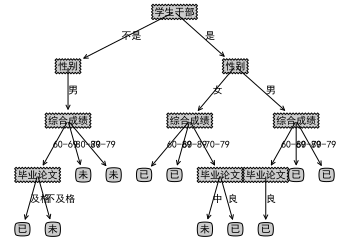

In [23]:
%config InlineBackend.figure_format = "svg"
with open('a.txt',encoding='utf-8') as f:
    fr = f.readlines()
tempDataSet = [line.strip('\n') for line in fr]
tempDataSet = np.array(tempDataSet).reshape(-1,6)
labels = list(tempDataSet[0][1 :])
print(labels)
dataSet = tempDataSet[1 :][:,1 :]
tree = createTree(dataSet,labels[:])
createPlot(tree)

In [25]:
1/32

0.03125